In [1]:
# Real life data

import logging
import threading
import itertools
import pandas as pd  
import numpy as np  
import scipy as sp
import ruptures as rpt
import json
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import axes3d
import seaborn as seabornInstance
from sqlalchemy import Column, Integer, String, Float, DateTime, Boolean, func
from iotfunctions import base
from iotfunctions import bif
from iotfunctions import entity
from iotfunctions import metadata
from iotfunctions.metadata import EntityType
from iotfunctions.db import Database
from iotfunctions.dbtables import FileModelStore
from iotfunctions.enginelog import EngineLogging
from iotfunctions import estimator
from iotfunctions.bif import PythonExpression
from iotfunctions.ui import (UISingle, UIMultiItem, UIFunctionOutSingle,
                 UISingleItem, UIFunctionOutMulti, UIMulti, UIExpression,
                 UIText, UIStatusFlag, UIParameters)
from iotfunctions.anomaly import (SaliencybasedGeneralizedAnomalyScore, SpectralAnomalyScore,
                 FFTbasedGeneralizedAnomalyScore, KMeansAnomalyScore, NoDataAnomalyScore,
                 SaliencybasedGeneralizedAnomalyScoreV2, FFTbasedGeneralizedAnomalyScoreV2, 
                 KMeansAnomalyScoreV2, BayesRidgeRegressor, RobustThreshold)
from mmfunctions.anomaly import (FeatureBuilder, GBMForecaster, KDEAnomalyScore1d,
                                 VIAnomalyScore, SpectralAnomalyScoreExt, MatrixProfileAnomalyScore,
                                 NoDataAnomalyScoreExt, ChangePointDetector, EnsembleAnomalyScore,
                                 GMMAnomalyScore)
import datetime as dt
#import pymc3 as pm
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn.mixture import BayesianGaussianMixture
from sklearn.pipeline import Pipeline
from sklearn import metrics
from pandas.plotting import register_matplotlib_converters
import matplotlib
import seaborn as sns
register_matplotlib_converters()

EngineLogging.configure_console_logging(logging.INFO)

In [2]:
db_schema=None
class DatabaseDummy:
    tenant_id = '###_IBM_###'
    db_type = 'db2'
    model_store = FileModelStore()
    def _init(self):
        return

db = DatabaseDummy()
        
print (db.tenant_id)

2022-04-20T15:30:12.530 INFO iotfunctions.dbtables.__init__ Init FileModelStore with path: 
###_IBM_###


In [3]:
Temperature = 'FLOATVALUE'
spectral = Temperature + '_spectral'
spectralinv = Temperature + '_spectralinv'
signal = Temperature + '_energy'
rob = Temperature + '_rob'
nodata = Temperature + '_nodata'
cpd = Temperature + '_cpd'
cpd_sig = Temperature + '_cpd_sig'
cpd_inv = Temperature + '_cpd_inv_sig'

### Well known ph metrics example

I keep it here because it's illustrative.
Although the distribution isn't perfect the GMM approach turns out to be quite effective.

In [28]:
# deviceid ac2efe94-842d-3679-9f63-2d5365e01a11
# tag path ca3e/sws/ait2107/eu
df1_raw = pd.read_csv('./data/IOT_TAGDATA_TYPE_202106151143_ca3e_sws_ait2107_eu.csv',
                     parse_dates=['RCV_TIMESTAMP_UTC'], infer_datetime_format=True)
df1_raw['RCV_TIMESTAMP_UTC'] = pd.to_datetime(df1_raw['RCV_TIMESTAMP_UTC'], 
                                            format='%Y-%m-%d-%H.%M.%S.%f')
df1_raw = df1_raw.sort_values('RCV_TIMESTAMP_UTC').\
                  drop(columns=['TAGID','INTVALUE','STRINGVALUE', 'UPDATED_UTC', 'DATEVALUE',
                               'EVT_NAME', 'DEVICETYPE', 'LOGICALINTERFACE_ID', 'EVENTTYPE', 'FORMAT',])
df1_i = df1_raw.set_index(['DEVICEID','RCV_TIMESTAMP_UTC'])
df1_t = df1_raw.drop(columns=['DEVICEID']).set_index('RCV_TIMESTAMP_UTC')

In [29]:
df1_t.to_csv('test.csv')

In [5]:
jobsettings = { 'db': db, 
               '_db_schema': 'public', 'save_trace_to_file' : True}

gmmi = SpectralAnomalyScoreExt(Temperature, 12, spectral, spectralinv, signal)
et = gmmi._build_entity_type(columns = [Column(Temperature,Float())], **jobsettings)
gmmi._entity_type = et
df1_i = gmmi.execute(df=df1_i)

2022-04-20T15:30:12.831 INFO iotfunctions.metadata.__init__ The entity type is not connected to a metric input table.
2022-04-20T15:30:12.832 INFO mmfunctions.anomaly.execute db is <__main__.DatabaseDummy object at 0x7fd8386c1520>
2022-04-20T15:30:12.856 INFO numexpr.utils._init_num_threads Note: NumExpr detected 12 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
2022-04-20T15:30:12.857 INFO numexpr.utils._init_num_threads NumExpr defaulting to 8 threads.


<AxesSubplot:>

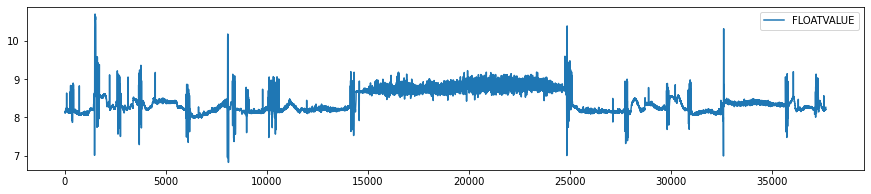

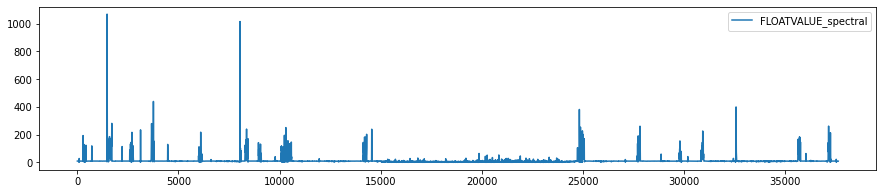

In [6]:
df1_i[['FLOATVALUE']].plot(use_index=False, figsize=(15,3))
df1_i[['FLOATVALUE_spectral']].plot(use_index=False, figsize=(15,3))

Text(0.5, 1.0, 'Almost bimodal distribution')

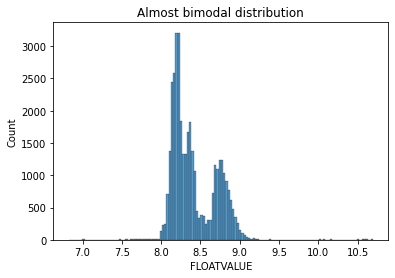

In [7]:
sns.histplot(data=df1_i[Temperature]).set_title('Almost bimodal distribution')

### Approximate bimodal distribution

by a sum of two Gaussians with a Gaussian Mixture Model

In [8]:
from mmfunctions.anomaly import GMMAnomalyScore
#EngineLogging.configure_console_logging(logging.DEBUG)
gmm1 = GMMAnomalyScore(Temperature, 2, 3, 'gmm')
gmm1.delete_model = True
et = gmm1._build_entity_type(columns = [Column(Temperature,Float())], **jobsettings)
gmm1._entity_type = et
df1_i = gmm1.execute(df=df1_i)

2022-04-20T15:30:15.899 INFO iotfunctions.metadata.__init__ The entity type is not connected to a metric input table.
2022-04-20T15:30:15.925 INFO iotfunctions.dbtables.retrieve_model Model model.TEST_ENTITY_FOR_GMMANOMALYSCORE.GMMAnomalyScore.gmm.ac2efe94-842d-3679-9f63-2d5365e01a11 of size 1927 bytes has been retrieved from filesystem
2022-04-20T15:30:15.931 INFO mmfunctions.anomaly.load_model load model Pipeline(steps=[('scale', MinMaxScaler()),
                ('gmm',
                 BayesianGaussianMixture(init_params='random', n_components=2,
                                         n_init=5, verbose=1,
                                         weight_concentration_prior_type='dirichlet_distribution'))])
Initialization 0
  Iteration 10
  Iteration 20
  Iteration 30
  Iteration 40
Initialization converged: True
Initialization 1
  Iteration 10
  Iteration 20
  Iteration 30
  Iteration 40
Initialization converged: True
Initialization 2
  Iteration 10
  Iteration 20
  Iteration 30
  

In [9]:
# generated model after applying a MinMaxScaler
BGM1 = gmm1.active_models['ac2efe94-842d-3679-9f63-2d5365e01a11']['gmm']
"weights", BGM1.weights_, "means", BGM1.means_, "precision", BGM1.precisions_

('weights',
 array([0.48540062, 0.51459938]),
 'means',
 array([[0.46397146],
        [0.36072276]]),
 'precision',
 array([[[ 178.45064387]],
 
        [[1914.22618737]]]))

### Export/Import as ONNX

In [10]:
pipe = gmm1.active_models['ac2efe94-842d-3679-9f63-2d5365e01a11']

In [11]:
pipe

Pipeline(steps=[('scale', MinMaxScaler()),
                ('gmm',
                 BayesianGaussianMixture(init_params='random', n_components=2,
                                         n_init=5, verbose=1,
                                         weight_concentration_prior_type='dirichlet_distribution'))])

In [12]:
id(pipe) # .named_steps['gmm'])

140566636288992

In [50]:
# Convert into ONNX format
from onnxruntime import InferenceSession
from skl2onnx import convert_sklearn
from skl2onnx.common.data_types import FloatTensorType
#from skl2onnx import to_onnx
from mlprodict.onnx_conv import to_onnx
from mlprodict.onnxrt import OnnxInference
from skl2onnx.helpers import collect_intermediate_steps
inp = df1_i.loc['ac2efe94-842d-3679-9f63-2d5365e01a11'][Temperature].values.reshape(-1, 1)

#onx = to_onnx(pipe, inp[:1].astype(np.float64),
onx = to_onnx(pipe, inp[:1],
              options={id(pipe.named_steps['gmm']): {'score_samples': True}})



(-0.5, 5623.5, 11828.5, -0.5)

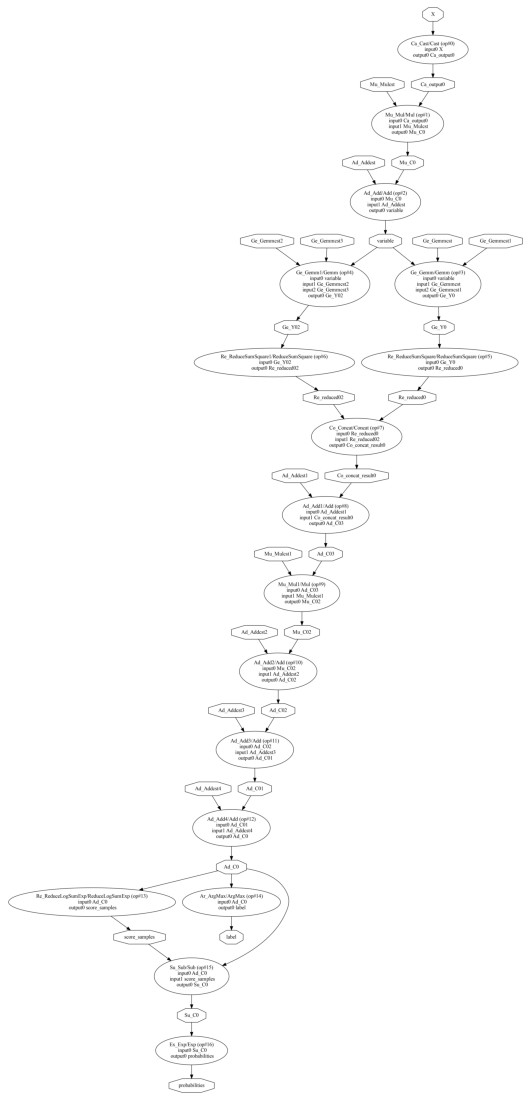

In [51]:
import os
from onnx.tools.net_drawer import GetPydotGraph, GetOpNodeProducer
pydot_graph = GetPydotGraph(onx.graph, name="Hallo", rankdir="TP",
                            node_producer=GetOpNodeProducer("docstring"))

pydot_graph.write_dot("gmm.dot")

os.system('dot -O -Gdpi=300 -Tpng gmm.dot')

image = plt.imread("gmm.dot.png")
fig, ax = plt.subplots(figsize=(12, 20))
ax.imshow(image)
ax.axis('off')

In [52]:
import onnx
onnx.save(onx, "/home/markus/src/pipeline-2.0-poc-kafka/com.ibm.wiotp.internal.pipeline.catalog/src/test/resources/NVTBimodal.onnx")

In [53]:
onnx_model = onnx.load('/home/markus/src/pipeline-2.0-poc-kafka/com.ibm.wiotp.internal.pipeline.catalog/src/test/resources/NVTBimodal.onnx')
print(onnx_model)

ir_version: 8
producer_name: "skl2onnx"
producer_version: "1.11.1"
domain: "ai.onnx"
model_version: 0
doc_string: ""
graph {
  node {
    input: "X"
    output: "Ca_output0"
    name: "Ca_Cast"
    op_type: "Cast"
    attribute {
      name: "to"
      i: 11
      type: INT
    }
    domain: ""
  }
  node {
    input: "Ca_output0"
    input: "Mu_Mulcst"
    output: "Mu_C0"
    name: "Mu_Mul"
    op_type: "Mul"
    domain: ""
  }
  node {
    input: "Mu_C0"
    input: "Ad_Addcst"
    output: "variable"
    name: "Ad_Add"
    op_type: "Add"
    domain: ""
  }
  node {
    input: "variable"
    input: "Ge_Gemmcst"
    input: "Ge_Gemmcst1"
    output: "Ge_Y0"
    name: "Ge_Gemm"
    op_type: "Gemm"
    attribute {
      name: "alpha"
      f: 1.0
      type: FLOAT
    }
    attribute {
      name: "beta"
      f: 1.0
      type: FLOAT
    }
    domain: ""
  }
  node {
    input: "variable"
    input: "Ge_Gemmcst2"
    input: "Ge_Gemmcst3"
    output: "Ge_Y02"
    name: "Ge_Gemm1"
    op_ty

In [54]:

#oinf = OnnxInference(onx, runtime='python_compiled')
#print(oinf.run({'X': inp.astype(np.float64)[:5]}))

sess = InferenceSession(onx.SerializeToString())

pred_ort_full = sess.run(['score_samples'], {'X' :inp})

pred_ort = pred_ort_full[0]

pred_skl = pipe.score_samples(inp.astype(np.float64))

print("Onnx Runtime prediction:\n", pred_ort[:5])
print("Sklearn prediction:\n", pred_skl[:5])

Onnx Runtime prediction:
 [[1.95827347]
 [1.85118239]
 [1.87558671]
 [1.78725737]
 [1.7262111 ]]
Sklearn prediction:
 [1.95827347 1.85118239 1.87558671 1.78725737 1.7262111 ]


In [60]:
df1_t['score'] = np.array(pred_ort_full).flatten()

In [65]:
df1_t2 = df1_t.drop(columns=['FLOATVALUE'])

In [68]:
df1_t2.to_csv('test.csv')

Text(0.5, 1.0, 'native')

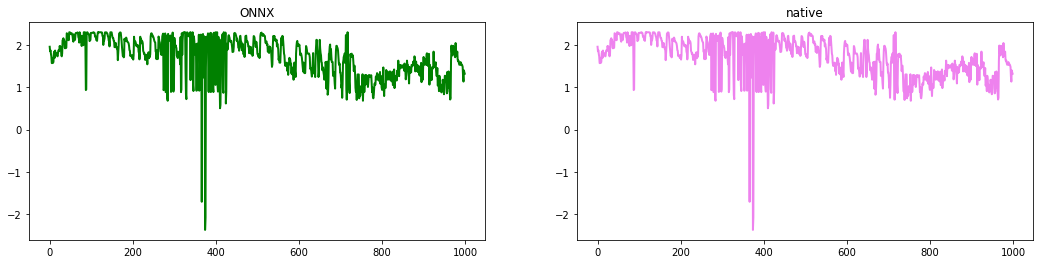

In [69]:
#rg = range(len(pred_skl))
fig, ax = plt.subplots(1,2,figsize=(18,4))
ax[0].plot(range(1000), pred_ort[:1000], color='green', lw=2)
ax[1].plot(range(1000), pred_skl[:1000], color='violet', lw=2)
ax[0].set_title('ONNX')
ax[1].set_title('native')



### Display the approximation with the additive model of two Gaussians

0 0 [[0.44715938]] [[0.48078224]]
1 1 [[0.35915542]] [[0.36228981]]


Text(0.5, 1.0, 'Gaussians after MinMax Scaling')

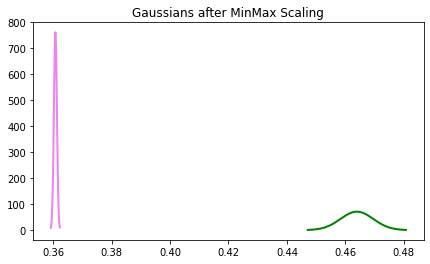

In [10]:
x = [None, None, None]
y = [None, None, None]
j = 0
for i in [0,1]:
    #mu = scaler.inverse_transform(BGM.means_[i])
    mu = BGM1.means_[i]
    sigma = 1/BGM1.precisions_[i]
    print (i, j, mu - 3*sigma, mu + 3*sigma)
    #x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
    x[j] = np.arange(mu - 3*sigma, mu + 3*sigma, 0.0001)

    #print (x)
    y[j] = sp.stats.norm.pdf(x[j], mu, sigma).reshape(-1,)
    j+=1
    #print (y)
    
fig, ax = plt.subplots(1,1,figsize=(7,4))
ax.plot(x[0], y[0], color='green', lw=2)
ax.plot(x[1], y[1], color='violet', lw=2)
ax.set_title('Gaussians after MinMax Scaling')
#ax.plot(x[2], y[2], color='blue', lw=2)

In [11]:
# Show the anomaly score - everything above 6.6 is an outlier as e^(-6.6) is roughly 3 standard deviations away)
arr = df1_i['gmm'].copy()
arr[arr > 6.6] = 7
arr[arr <= 6.6] = np.nan

df1_i['anom'] = arr


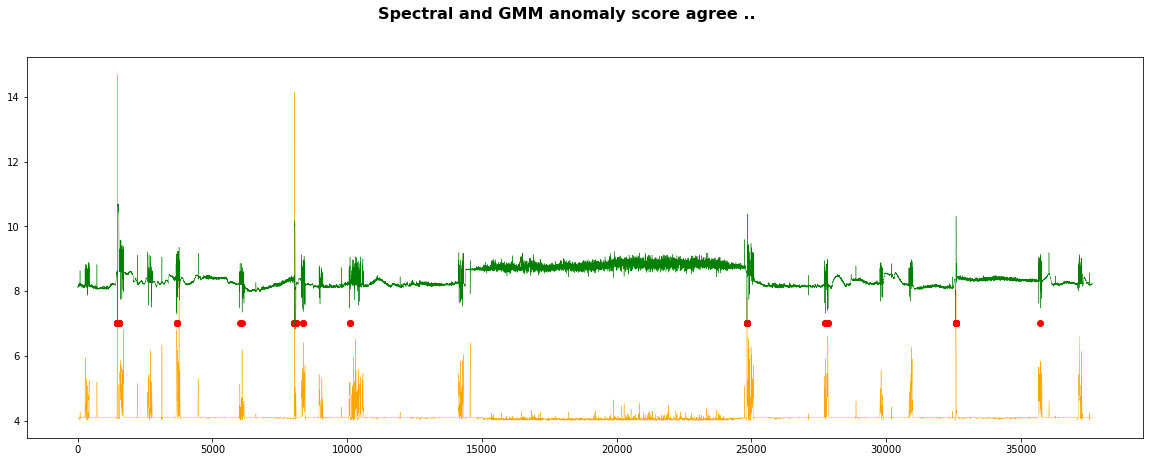

In [12]:
#df1_i[['FLOATVALUE','gmm','anom']].plot(figsize=(15,7))
arr = np.arange(0,arr.size)

fig, ax = plt.subplots(1,1,figsize=(20,7))
fig.suptitle('Spectral and GMM anomaly score agree ..', fontsize=16, fontweight='bold')

ax.plot(arr, df1_i['FLOATVALUE'], color='green', lw=0.4)
#ax.plot(arr, df1_i['gmm'], color='violet', lw=0.4)
ax.scatter(arr, df1_i['anom'], color='red', lw=1)
ax.plot(arr, df1_i['FLOATVALUE_spectral']/100 + 4, color='orange', zorder=-1, lw=0.4)

### Digression Approximate distribution via Kernel Density estimates

this is slightly more accurate but by far **more expensive** to score

In [13]:
#EngineLogging.configure_console_logging(logging.DEBUG)
kde1 = KDEAnomalyScore1d(Temperature, 0.000001, 'kde')
kde1.delete_model = True
et = kde1._build_entity_type(columns = [Column(Temperature,Float())], **jobsettings)
kde1._entity_type = et
df1_i = kde1.execute(df=df1_i)

2022-02-02T17:14:02.276 INFO iotfunctions.metadata.__init__ The entity type is not connected to a metric input table.
2022-02-02T17:14:02.305 INFO iotfunctions.dbtables.retrieve_model Model model.TEST_ENTITY_FOR_KDEANOMALYSCORE1D.KDEAnomalyScore1d.kde.ac2efe94-842d-3679-9f63-2d5365e01a11 of size 652432 bytes has been retrieved from filesystem
2022-02-02T17:14:02.306 INFO mmfunctions.anomaly.load_model load model KernelDensity(bandwidth=0.2)
(37645, 1) (37645, 1) (37645, 1)


In [14]:
arr = -df1_i['kde'].values
arr[arr < 6.607650687] = np.nan
df1_i['kde+'] = arr

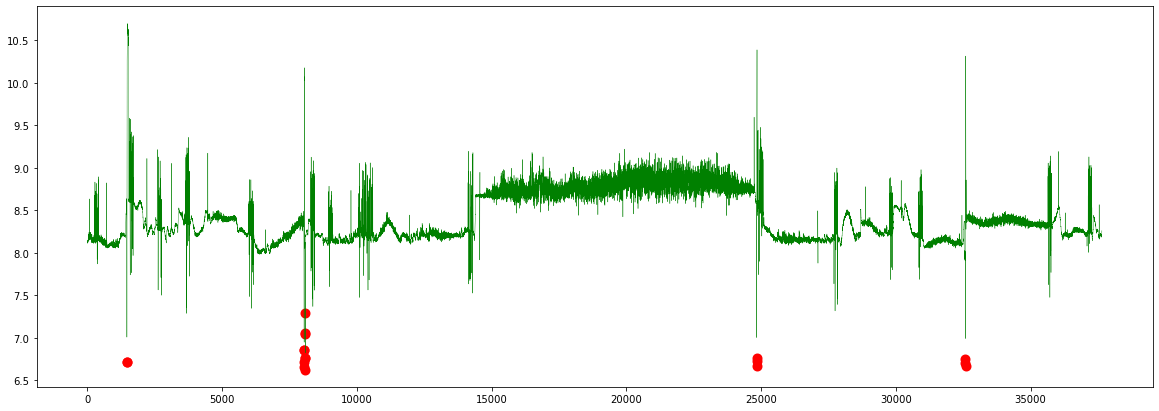

In [15]:
#df1_i[['FLOATVALUE','gmm','anom']].plot(figsize=(15,7))
arr = np.arange(0, df1_i['FLOATVALUE'].values.size)

fig, ax = plt.subplots(1,1,figsize=(20,7))
ax.plot(arr, df1_i['FLOATVALUE'], color='green', lw=0.4)
#ax.plot(arr, df1_i['gmm'], color='violet', lw=0.4)
ax.scatter(arr, df1_i['kde+'], color='red', lw=4)

### Try GMM with more data

In [16]:
num_of_rows = 1024

CSV_Reader = pd.read_csv('./data/IOT_TAGDATA_202112021356.csv.bz2', compression='bz2',
                     parse_dates=['RCV_TIMESTAMP_UTC'], infer_datetime_format=True, chunksize=num_of_rows)
dfs = []
i = 0
for chunk_df in CSV_Reader:
    chunk_df['RCV_TIMESTAMP_UTC'] = pd.to_datetime(chunk_df['RCV_TIMESTAMP_UTC'], format='%Y-%m-%d-%H.%M.%S.%f')
    chunk_df = chunk_df.sort_values('RCV_TIMESTAMP_UTC') #.drop(columns=['TAGID','INTVALUE','STRINGVALUE',
                                                         #              'DATEVALUE','EVT_NAME','DEVICETYPE',
                                                         #              'LOGICALINTERFACE_ID','EVENTTYPE',
                                                         #              'FORMAT','UPDATED_UTC'])
    #chunk_df['FLOATVALUE'].astype(np.float64)
    i+=1
    dfs.append(chunk_df)
    if i > 4000: break
    
df3_raw = pd.concat(dfs, sort=False)

df3_i = df3_raw.sort_values(by=['RCV_TIMESTAMP_UTC']).set_index(['DEVICEID','RCV_TIMESTAMP_UTC'])

### Got all sensors with tag path matching 'ca3e/hvac/scrubbers/shx*'

In [17]:
df3_i['TAG'].unique()

array(['ca3e/hvac/scrubbers/shx7/fit701/eu',
       'ca3e/hvac/scrubbers/shx1/at103/eu',
       'ca3e/hvac/scrubbers/shx1/fit102/eu',
       'ca3e/hvac/scrubbers/shx1/pt101/eu',
       'ca3e/hvac/scrubbers/shx3/at303/eu',
       'ca3e/hvac/scrubbers/shx3/recirctotflow/eu',
       'ca3e/hvac/scrubbers/shx2/at202/eu',
       'ca3e/hvac/scrubbers/shx1/recirctotflow/eu',
       'ca3e/hvac/scrubbers/shx3/fit301/eu',
       'ca3e/hvac/scrubbers/shx3/fit304/eu',
       'ca3e/hvac/scrubbers/shx3/fit302/eu',
       'ca3e/hvac/scrubbers/shx1/fit101/eu',
       'ca3e/hvac/scrubbers/shx3/fan/current',
       'ca3e/hvac/scrubbers/shx3/dpit302/eu',
       'ca3e/hvac/scrubbers/shx1/fit104/eu',
       'ca3e/hvac/scrubbers/shx1/dpit102/eu',
       'ca3e/hvac/scrubbers/shx7/shx7/fan/torque',
       'ca3e/hvac/scrubbers/shx7/shx7/fan/power',
       'ca3e/hvac/scrubbers/shx7/shx7/fan/current',
       'ca3e/hvac/scrubbers/shx1/dpit103/eu',
       'ca3e/hvac/scrubbers/shx7/fit704/eu',
       'ca3e/hvac/scru

### Plotting the first 4 of the list

In [18]:
tag_list = [
            'ca3e/hvac/scrubbers/shx1/at103/eu', 'ca3e/hvac/scrubbers/shx1/pt101/eu',
            'ca3e/hvac/scrubbers/shx1/fit101/eu', 'ca3e/hvac/scrubbers/shx1/fit102/eu',
            'ca3e/hvac/scrubbers/shx1/fit104/eu']

# empty - i.e. suitable data points but we don't have data in db2
#   'ca3e/hvac/scrubbers/shx1/at101/eu', 'ca3e/hvac/scrubbers/shx1/at102/eu', 
#   'ca3e/hvac/scrubbers/shx1/pdit101/eu', 'ca3e/hvac/scrubbers/shx1/pdit102/eu',
#   'ca3e/hvac/scrubbers/shx2/at101/eu', 'ca3e/hvac/scrubbers/shx2/at102/eu',
#   'ca3e/hvac/scrubbers/shx2/at103/eu', 'ca3e/hvac/scrubbers/shx2/pt101/eu',
#   'ca3e/hvac/scrubbers/shx2/pdit101/eu', 'ca3e/hvac/scrubbers/shx2/pdit102/eu',
#   'ca3e/hvac/scrubbers/shx2/fit101/eu', 'ca3e/hvac/scrubbers/shx2/fit102/eu',
#   'ca3e/hvac/scrubbers/shx3/at101/eu', 'ca3e/hvac/scrubbers/shx3/at102/eu',
#   'ca3e/hvac/scrubbers/shx2/fit104/eu', 
# 


ca3e/hvac/scrubbers/shx1/at103/eu
ca3e/hvac/scrubbers/shx1/pt101/eu
ca3e/hvac/scrubbers/shx1/fit101/eu
ca3e/hvac/scrubbers/shx1/fit102/eu


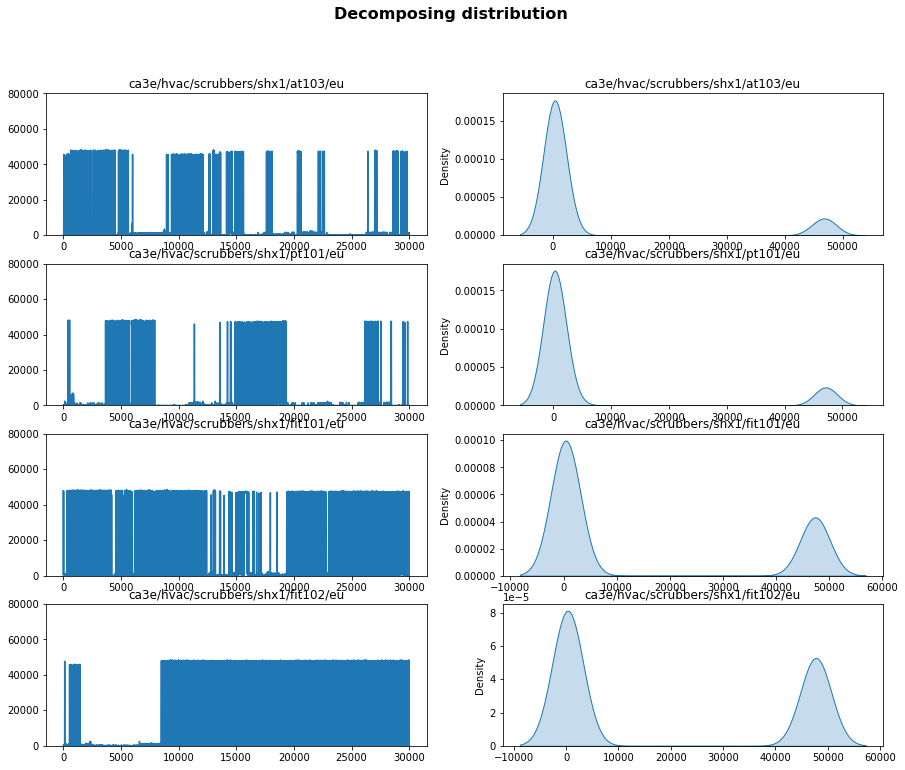

In [19]:
#tag_list = []
i = 0
last = 4

fig, ax = plt.subplots(last, 2, figsize=(15, 3*last),squeeze=False)
fig.suptitle("Decomposing distribution", fontsize=16, fontweight='bold')


#for tag in df3_i['TAG'].unique():
for tag in tag_list:
    
    #tag_list.append(tag)
    print(tag)
    arr = df3_i[df3_i['TAG'] == tag]['FLOATVALUE'][0:30000].values

    ax[i,0].plot(range(arr.size), arr)
    ax[i,0].set_ylim(0, 80000)
    ax[i,0].set_title(tag)
    sns.kdeplot(arr,ax=ax[i,1], fill=True)
    ax[i,1].set_title(tag)

    i+=1
    if i >= last: break

In [20]:
df = df3_i[df3_i['TAG'].isin(tag_list)].reset_index().set_index(['TAG','RCV_TIMESTAMP_UTC'])

In [21]:
df

DEVICEID  \
TAG                                RCV_TIMESTAMP_UTC                                               
ca3e/hvac/scrubbers/shx1/at103/eu  2021-11-01 00:00:06.669  abc99a29-0482-38c6-8b25-22b71bcc0f3f   
                                   2021-11-01 00:00:06.669  abc99a29-0482-38c6-8b25-22b71bcc0f3f   
                                   2021-11-01 00:00:06.669  3631be71-d40e-34e6-af37-daa204642605   
ca3e/hvac/scrubbers/shx1/fit102/eu 2021-11-01 00:00:06.669  e19c13e1-73a1-3222-8778-aee8d5c94004   
ca3e/hvac/scrubbers/shx1/at103/eu  2021-11-01 00:00:06.669  abc99a29-0482-38c6-8b25-22b71bcc0f3f   
...                                                                                          ...   
                                   2021-12-01 16:59:08.949  a026f5e3-6817-3d28-bbbc-068527bfb104   
                                   2021-12-01 16:59:08.949  a026f5e3-6817-3d28-bbbc-068527bfb104   
                                   2021-12-01 16:59:08.949  a026f5e3-6817-3d28-bbbc-068527bfb104   
                                   2021-12-01 16:59:08.949  a026f5e3-6817-3d28-bbbc-068527bfb104   
                                   2021-12-01 16:59:08.949  a026f5e3-6817-3d28-bbbc-068527bfb104   

                                                             TAGID  FLOATVALUE  
TAG                                RCV_TIMESTAMP_UTC                            
ca3e/hvac/scrubbers/shx1/at103/eu  2021-11-01 00:00:06.669  674652    2.400000  
                                   2021-11-01 00:00:06.669  674652    2.400000  
                                   2021-11-01 00:00:06.669  674654  243.000000  
ca3e/hvac/scrubbers/shx1/fit102/eu 2021-11-01 00:00:06.669  674696  253.000000  
ca3e/hvac/scrubbers/shx1/at103/eu  2021-11-01 00:00:06.669  674652    2.400000  
...                                                            ...         ...  
                                   2021-12-01 16:59:08.949  639238    1.590226  
                                   2021-12-01 16:59:08.949  639238    1.590226  
                                   2021-12-01 16:59:08.949  639238    1.590226  
                                   2021-12-01 16:59:08.949  639238    1.590226  
                                   2021-12-01 16:59:08.949  639238    1.590226  

[1066009 rows x 3 columns]

In [22]:
jobsettings = { 'db': db, 
               '_db_schema': 'public', 'save_trace_to_file' : True}

gmm2 = GMMAnomalyScore(Temperature, 2, 3, 'gmm')
gmm2.delete_model = True
et = gmm2._build_entity_type(columns = [Column(Temperature,Float())], **jobsettings)
gmm2._entity_type = et
df = gmm2.execute(df=df)

2022-02-02T17:15:22.552 INFO iotfunctions.metadata.__init__ The entity type is not connected to a metric input table.
2022-02-02T17:15:22.801 INFO iotfunctions.dbtables.retrieve_model Model model.TEST_ENTITY_FOR_GMMANOMALYSCORE.GMMAnomalyScore.gmm.ca3e:hvac:scrubbers:shx1:at103:eu of size 1930 bytes has been retrieved from filesystem
2022-02-02T17:15:22.804 INFO mmfunctions.anomaly.load_model load model Pipeline(steps=[('scale', MinMaxScaler()),
                ('gmm',
                 BayesianGaussianMixture(init_params='random', n_components=2,
                                         n_init=5, verbose=1,
                                         weight_concentration_prior_type='dirichlet_distribution'))])
Initialization 0
Initialization converged: True
Initialization 1
Initialization converged: True
Initialization 2
Initialization converged: True
Initialization 3
Initialization converged: True
Initialization 4
Initialization converged: True
(88368, 1) (88368, 1)
2022-02-02T17:15:24.1

Text(0.5, 1.0, 'anomaly score')

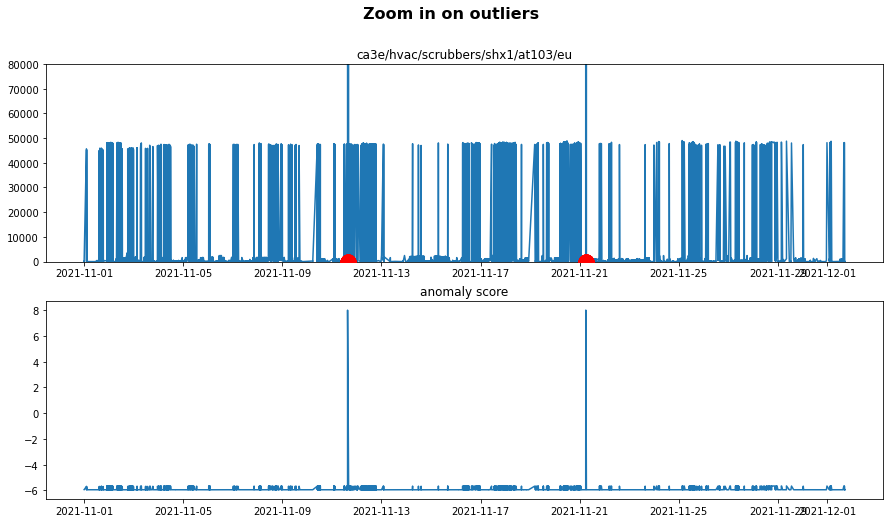

In [23]:
tag = 'ca3e/hvac/scrubbers/shx1/at103/eu'

threshold = 4.6
df_ = df.loc[tag].copy().reset_index()
#df_['gmm'] *= 3000000
garr = df_['gmm'].values.copy()

garr[garr <= threshold] = np.nan #-1
garr[garr > threshold] = 0

fig, ax = plt.subplots(2,1, figsize=(15, 8),squeeze=False)

fig.suptitle("Zoom in on outliers", fontsize=16, fontweight='bold')



ax[0,0].plot(df_['RCV_TIMESTAMP_UTC'].values, df_['FLOATVALUE'].values)
ax[0,0].set_ylim(0, 80000)
ax[0,0].scatter(df_['RCV_TIMESTAMP_UTC'].values, garr, c='red', lw=10, zorder=10)
ax[0,0].set_title(tag)
ax[1,0].plot(df_['RCV_TIMESTAMP_UTC'].values, df_['gmm'].values)
ax[1,0].set_title('anomaly score')
#df_.loc[tag].plot()
#df3_i[df3_i['TAG'] == tag].plot()

In [24]:
#df_.loc[tag].size

ca3e/hvac/scrubbers/shx1/at103/eu
ca3e/hvac/scrubbers/shx1/pt101/eu
ca3e/hvac/scrubbers/shx1/fit101/eu
ca3e/hvac/scrubbers/shx1/fit102/eu


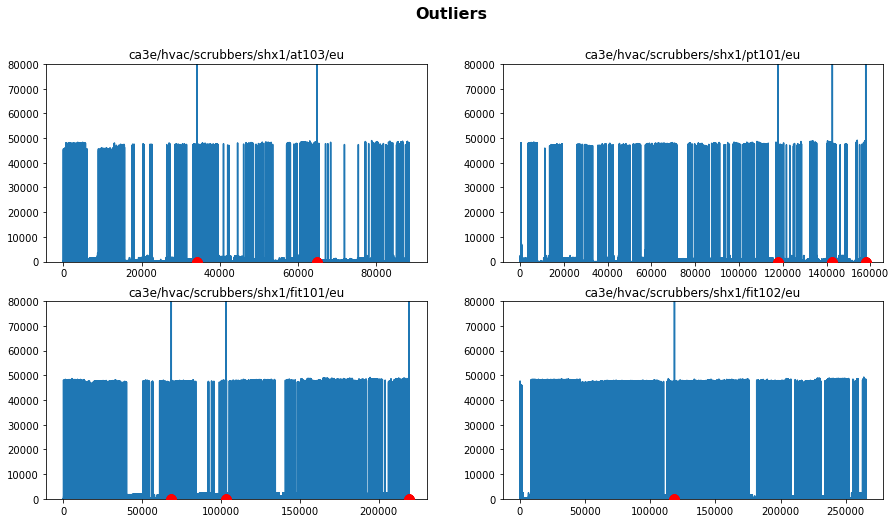

In [25]:

# predictions = negative log-likelihood for sample after scaling
threshold = 4.6 # prob lower than ~1%

i = 0
last = 4

df_ = df.reset_index()

fig, ax = plt.subplots(last//2,2, figsize=(15, 2*last),squeeze=False)

fig.suptitle("Outliers", fontsize=16, fontweight='bold')


for tag in tag_list: #df_['TAG'].unique():
    
    print(tag)
    arr = df_[df_['TAG'] == tag]['FLOATVALUE'].values
    garr = df_[df_['TAG'] == tag]['gmm'].values
    
    #garr[garr < 0] = 0
    garr[garr <= threshold] = np.nan #-1
    garr[garr > threshold] = 0
    #garr[garr < 0] = np.nan


    ax[i//2, i%2].plot(range(arr.size), arr)
    ax[i//2, i%2].scatter(range(garr.size), garr, color='red', zorder=10, lw=4)
    ax[i//2, i%2].set_ylim(0,80000)
    ax[i//2, i%2].set_title(tag)

    i+=1
    if i >= last: break

#### -- snip -- snip -- snip --

Ignore everything below

In [26]:
df_

,TAG,RCV_TIMESTAMP_UTC,DEVICEID,TAGID,FLOATVALUE,gmm
0,ca3e/hvac/scrubbers/shx1/at103/eu,2021-11-01 00:00:06.669,abc99a29-0482-38c6-8b25-22b71bcc0f3f,674652,2.400000,-5.944272
1,ca3e/hvac/scrubbers/shx1/at103/eu,2021-11-01 00:00:06.669,abc99a29-0482-38c6-8b25-22b71bcc0f3f,674652,2.400000,-5.944272
2,ca3e/hvac/scrubbers/shx1/at103/eu,2021-11-01 00:00:06.669,3631be71-d40e-34e6-af37-daa204642605,674654,243.000000,-5.944713
3,ca3e/hvac/scrubbers/shx1/at103/eu,2021-11-01 00:00:06.669,abc99a29-0482-38c6-8b25-22b71bcc0f3f,674652,2.400000,-5.944272
4,ca3e/hvac/scrubbers/shx1/at103/eu,2021-11-01 00:00:06.669,abc99a29-0482-38c6-8b25-22b71bcc0f3f,674652,2.400000,-5.944272
...,...,...,...,...,...,...
1066004,ca3e/hvac/scrubbers/shx1/at103/eu,2021-12-01 16:59:08.949,a026f5e3-6817-3d28-bbbc-068527bfb104,639238,1.590226,-5.944270
1066005,ca3e/hvac/scrubbers/shx1/at103/eu,2021-12-01 16:59:08.949,a026f5e3-6817-3d28-bbbc-068527bfb104,639238,1.590226,-5.944270
1066006,ca3e/hvac/scrubbers/shx1/at103/eu,2021-12-01 16:59:08.949,a026f5e3-6817-3d28-bbbc-068527bfb104,639238,1.590226,-5.944270
1066007,ca3e/hvac/scrubbers/shx1/at103/eu,2021-12-01 16:59:08.949,a026f5e3-6817-3d28-bbbc-068527bfb104,639238,1.590226,-5.944270


### Decompose into a mix of Gaussians

or something else if it makes sense and you care to derive the formula for the combined log-likelihood.

Apparently I copied it from another notebook for another customer in Spring 2021 ...
which I used as excuse to dabble a bit in MCMC ;-)

$$
  \log p(x) = -\frac{k \log(2 \pi)}{2} + \log( \frac{1}{\det (T)}) + (x - \mu) T (x - \mu)
$$

In [27]:
# https://docs.pymc.io/notebooks/gaussian-mixture-model-advi.html
import pymc3 as pm
import theano.tensor as tt

from pymc3 import (NUTS, DensityDist, Dirichlet, HalfCauchy, LKJCorr,
                   Metropolis, MvNormal, Normal, Slice, find_MAP, sample)
from pymc3.math import logsumexp
from theano.tensor.nlinalg import det

logging.getLogger("filelock").setLevel(logging.ERROR)


# Log likelihood of normal distribution
def logp_normal(mu, tau, value):
    # log probability of individual samples
    k = tau.shape[0]
    delta = lambda mu: value - mu
    return (-1 / 2.0) * (
        k * tt.log(2 * np.pi)
        + tt.log(1.0 / det(tau))
        + (delta(mu).dot(tau) * delta(mu)).sum(axis=1)
    )

In [28]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
scaler = RobustScaler()
data_ = scaler.fit_transform(df_['FLOATVALUE'].values.reshape(-1,1))

# turn it into 2-dim data for testing purposes
data = np.hstack([data_[0:10000], data_[0:10000]])
data = data_[0:10000]
data.shape

(10000, 1)

In [29]:
p=3
mu=[.03,.05,-.02]
cov_matrix= [[.025,0.0075, 0.00175],[0.0075,.007,0.00135],[0.00175,0.00135,.00043]]

n_obs=10000
x=np.random.multivariate_normal(mu,cov_matrix,n_obs)

prior_mu=np.ones(p)

prior_sigma = np.eye(p)
print(prior_mu,'\n', prior_sigma)


with pm.Model() as model:
    post_mu = pm.Normal("returns", prior_mu, 1, shape=3)  #, size=p)
    #post_cov_matrix_inv = pm.Wishart("cov_matrix_inv",n_obs,np.eye(3) )
    
    prec = pm.WishartBartlett('prec', np.eye(3), 5)
    post_cov_matrix_inv = pm.Deterministic('cov', tt.nlinalg.matrix_inverse(prec))

    obs = pm.MvNormal( "observed returns", post_mu, post_cov_matrix_inv, observed=x )
    
    #mcmc = pm.MCMC()
'''

mcmc.sample( 5000, 2000, 3 )

mu_samples = mcmc.trace("returns")[:]
mu_samples.mean(axis=0)
cov_inv_samples = mcmc.trace("cov_matrix_inv")[:]
mean_covariance_matrix = np.linalg.inv( cov_inv_samples.mean(axis=0) )
'''

[1. 1. 1.] 
 [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
2022-02-02T17:16:23.924 INFO pymc3.WishartBartlett Added new variable prec_c to model diagonal of Wishart.
2022-02-02T17:16:23.980 INFO pymc3.WishartBartlett Added new variable prec_z to model off-diagonals of Wishart.


'\n\nmcmc.sample( 5000, 2000, 3 )\n\nmu_samples = mcmc.trace("returns")[:]\nmu_samples.mean(axis=0)\ncov_inv_samples = mcmc.trace("cov_matrix_inv")[:]\nmean_covariance_matrix = np.linalg.inv( cov_inv_samples.mean(axis=0) )\n'

In [30]:
with model:
    #%time approx = pm.fit(n=400, obj_optimizer=pm.adagrad(learning_rate=1e-1))
    %time approx = pm.fit(n=4000, obj_optimizer=pm.adadelta())

2022-02-02T17:16:45.946 INFO pymc3.variational.inference._iterate_with_loss Finished [100%]: Average Loss = -33,398
CPU times: user 1min 9s, sys: 1min 19s, total: 2min 29s
Wall time: 20.6 s


In [31]:
means = approx.bij.rmap(approx.mean.eval())
cov = approx.cov.eval()
sds = approx.bij.rmap(np.diag(cov) ** 0.5)

In [32]:
sds

{'prec_z': array([0.29665503, 0.36433718, 0.37965189]),
 'returns': array([0.01889656, 0.01696194, 0.01547676]),
 'prec_c_log__': array([0.0651494 , 0.09473671, 0.14631035])}

In [33]:
#sns.histplot(data=data.T).set_title('Almost bimodal distribution')

$$
  p(x) = \sum \phi_i \mathcal{N}(x | \mu_i, \sigma_i)
$$

In [34]:
# define simplified model - we expect our 2-dim data generated by 2 additive gaussians
ncomp = 2
dim = data.shape[1]

# Log likelihood of Gaussian mixture distribution
#   takes the list of mys, 
def logp_gmix(mus, phi, tau):
    def logp_(value):
        #print(tau.shape, mus, phi.shape)
        
        # ps  is list of probability for each Gaussian * how likely the value is for that Gaussian
        logps = [tt.log(phi[i]) + logp_normal(mu, tau, value) for i, mu in enumerate(mus)]
        print(logps)
        # unravel and add up
        print (logsumexp(tt.stacklists(logps)[:, :data.shape[0]], axis=0))
        return tt.sum(logsumexp(tt.stacklists(logps)[:, :data.shape[0]], axis=0))

    return logp_



with pm.Model() as model:
    
    # start with 2 normal dists
    mus = [
        MvNormal("mu_%d" % i, mu=pm.floatX(np.zeros(dim)), tau=pm.floatX(0.1 * np.eye(dim)), shape=(dim,))
        for i in range(ncomp)
    ]
    # usually we would draw mean and precision matrix from Normal, resp. Wishart
    #   but Wishart doesn't 
    
    # prior for the Gaussian components
    phi = Dirichlet("phi", a=pm.floatX(0.1 * np.ones(ncomp)), shape=(ncomp,))
    xs = DensityDist("x", logp_gmix(mus, phi, np.eye(dim)), observed=data)
    
    # Specify the likelihood
    #Y_obs = pm.Normal('Y_obs', mu=mu[z], sd=sigma[z], observed=y)

[Elemwise{add,no_inplace}.0, Elemwise{add,no_inplace}.0]
Elemwise{add,no_inplace}.0
[Elemwise{add,no_inplace}.0, Elemwise{add,no_inplace}.0]
Elemwise{add,no_inplace}.0
[Elemwise{add,no_inplace}.0, Elemwise{add,no_inplace}.0]
Elemwise{add,no_inplace}.0


In [35]:
%%time

'''
with model:
    start = find_MAP()
    step = Slice()
    trace = sample(100, step, start=start)

'''
with model:
    #%time approx = pm.fit(n=400, obj_optimizer=pm.adagrad(learning_rate=1e-1))
    %time approx = pm.fit(n=4000, obj_optimizer=pm.adadelta())

#'''
means = approx.bij.rmap(approx.mean.eval())
cov = approx.cov.eval()
sds = approx.bij.rmap(np.diag(cov) ** 0.5)

2022-02-02T17:16:52.784 INFO pymc3.variational.inference._iterate_with_loss Finished [100%]: Average Loss = 23,386
CPU times: user 5.05 s, sys: 38 ms, total: 5.09 s
Wall time: 5.57 s
CPU times: user 5.07 s, sys: 38.1 ms, total: 5.1 s
Wall time: 5.59 s


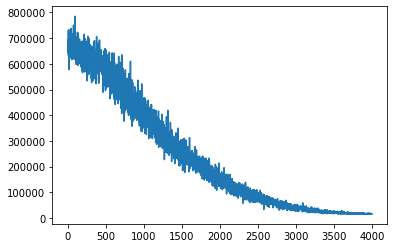

In [36]:
plt.plot(approx.hist)

In [37]:
sds

{'phi_stickbreaking__': array([0.02171003]),
 'mu_1': array([0.04217372]),
 'mu_0': array([0.43234801])}

IndexError: index 1 is out of bounds for axis 0 with size 1

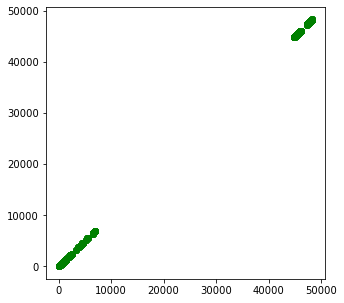

In [38]:
mu_0, mu_1 = scaler.inverse_transform(np.array([means["mu_0"], means["mu_1"]]))
data2 = scaler.inverse_transform(data)#[:, 0])

plt.figure(figsize=(5, 5))
plt.scatter(data2, data2, alpha=0.5, c="g")
#mu_0, mu_1 = means["mu_0"], means["mu_1"]
plt.scatter(mu_0[0], mu_0[1], c="r", lw=10, s=10)
plt.scatter(mu_1[0], mu_1[1], c="b", lw=10, s=10)
#plt.xlim(-6, 6)
#plt.ylim(-6, 6)


In [39]:
import theano.tensor as tt
data = df_input['temp'].values
ndata = data.size

model = pm.Model()
with model:
    # cluster sizes
    p = pm.Dirichlet("p", a=np.array([1.0, 1.0]), shape=2)
    # ensure all clusters have some points
    p_min_potential = pm.Potential("p_min_potential", tt.switch(tt.min(p) < 0.1, -np.inf, 0))

    # cluster centers
    means = pm.Normal("means", mu=[0, 0], sigma=15, shape=2)
    # break symmetry
    '''
    order_means_potential = pm.Potential(
        "order_means_potential",
        tt.switch(means[1] - means[0] < 0, -np.inf, 0)
        + tt.switch(means[2] - means[1] < 0, -np.inf, 0),
    )
    '''

    # measurement error
    sd = pm.Uniform("sd", lower=0, upper=20)

    # latent cluster of each observation
    category = pm.Categorical("category", p=p, shape=ndata)

    # likelihood for each observed value
    points = pm.Normal("obs", mu=means[category], sigma=sd, observed=data)

NameError: name 'df_input' is not defined

In [ ]:
map_estimate = pm.find_MAP(model=model) #, method="powell")

In [ ]:
map_estimate

In [ ]:
# fit model
with model:
    step1 = pm.Metropolis(vars=[p, sd, means])
    step2 = pm.CategoricalGibbsMetropolis(vars=[category], proposal = 'uniform')
    tr = pm.sample(10000, step=[step1, step2], tune=2000)

In [ ]:
pm.traceplot(tr, var_names=["p", "sd", "means"]);

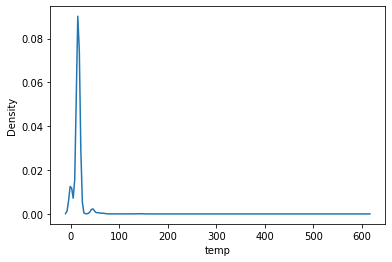

In [104]:
sns.kdeplot(data=df_input2['temp'])

<Figure size 1728x720 with 0 Axes>

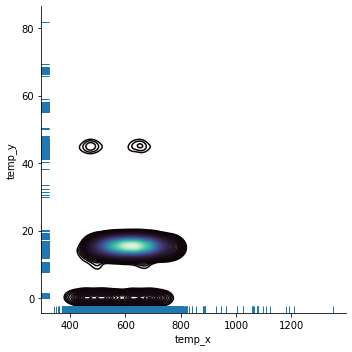

In [89]:
df_merge2 = df_merge.copy()
df_merge2 = df_merge2[df_merge2['temp_y'] < 100]

import seaborn as sns
plt.figure(figsize=(24, 10))
gx = sns.displot(df_merge2[['temp_x','temp_y']], x='temp_x', y='temp_y', 
                 levels=100, kind="kde", cmap="mako", rug=True)
    
#gx.set_titles('KDE for' + df_clean.index.levels[0].values[0])